In [140]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm  
import numpy as np
import seaborn as sns
import plotly.express as px
import ast

In [141]:
data = pd.read_csv("data_preprocessed_classification.csv")
data = data[['meals']]  
data = data[data['meals'] != "[]"] 
data.reset_index(drop=True, inplace=True) 
data['meals'] = data['meals'].apply(ast.literal_eval)
data['meals'] = data['meals'].apply(lambda meals: [dish.lower().strip() for dish in meals])
dish_mapping = {
    "biriyani": "biryani",
    "veggie": "veg",
    "non veg": "non-veg",
    
}
data['meals'] = data['meals'].apply(lambda meals: [dish_mapping.get(dish, dish) for dish in meals])
data.head()

,meals
0,[penne alfredo pasta]
1,"[kodi drumsticks, basket mutton biryani]"
2,"[corn, tawa fish, basket biryani, biryani]"
3,[chili honey lotus stem]
4,"[soup, honey chilli lotus]"


In [142]:
def cooccurrence_matrix_meals_generator(meals):

    co_occurrences = defaultdict(Counter)

    for meal_list in tqdm(meals):
        for dish1 in meal_list:
            for dish2 in meal_list:
                if dish1 != dish2:
                    co_occurrences[dish1][dish2] += 1


    unique_dishes = list(set(dish for meal_list in meals for dish in meal_list))

    
    co_matrix = np.zeros((len(unique_dishes), len(unique_dishes)), dtype=int)

   
    dish_index = {dish: idx for idx, dish in enumerate(unique_dishes)}
    for dish, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[dish_index[dish]][dish_index[neighbor]] = count

    
    co_matrix_df = pd.DataFrame(co_matrix, index=unique_dishes, columns=unique_dishes)

    
    #sorted_indices = co_matrix_df.sum(axis=1).sort_values(ascending=False).index
    #co_matrix_df = co_matrix_df.loc[sorted_indices, sorted_indices]
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)
    return co_matrix_df

# Generate the co-occurrence matrix
meals_co_occurrence = cooccurrence_matrix_meals_generator(data['meals'].tolist())

100%|██████████| 5904/5904 [00:00<00:00, 45774.23it/s]


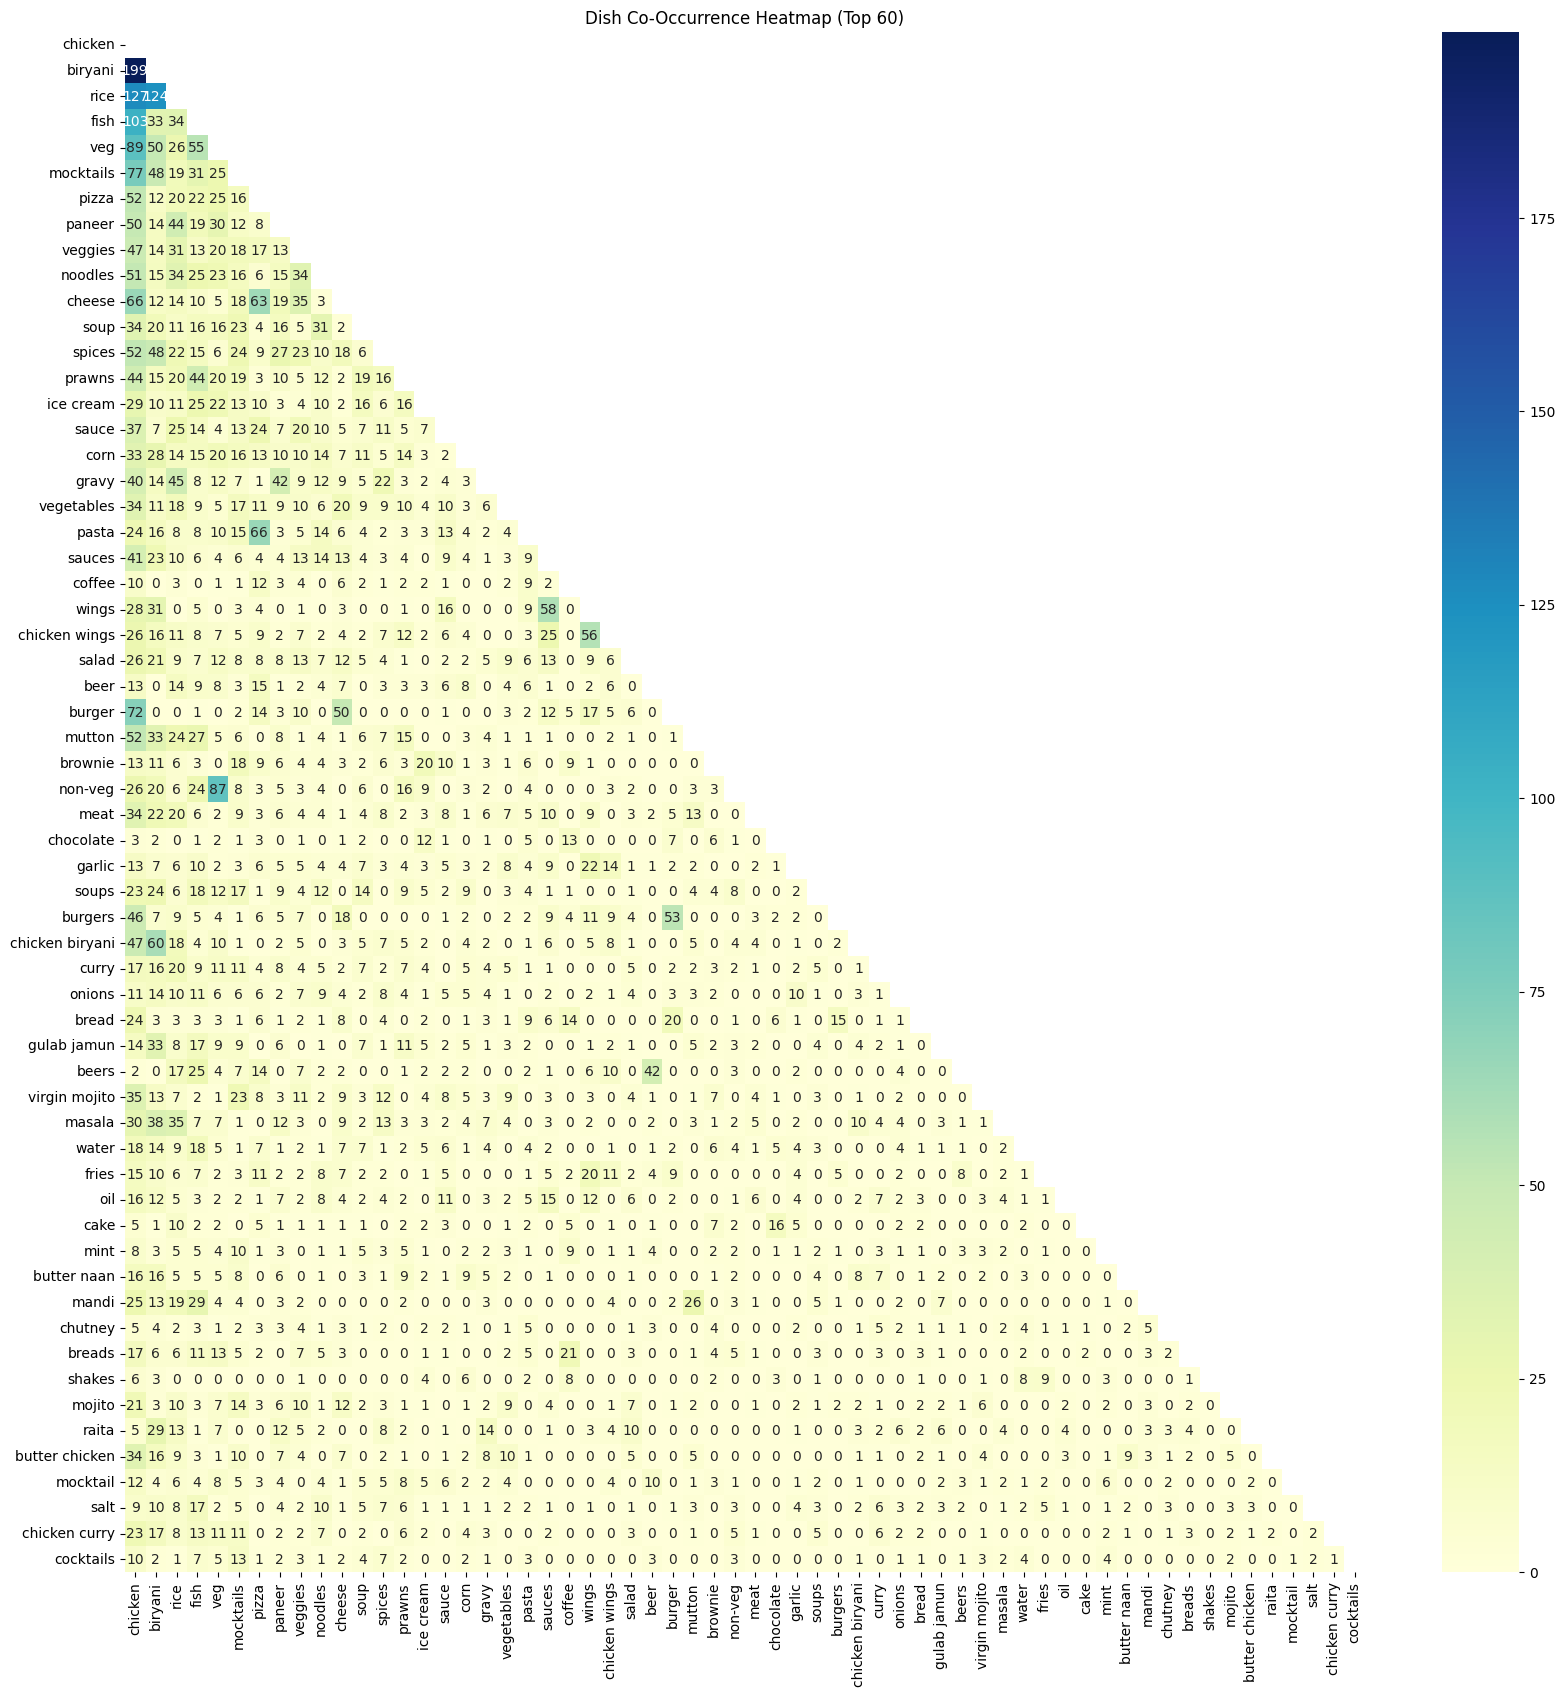

In [143]:
mask = np.triu(np.ones_like(meals_co_occurrence.iloc[:60, :60], dtype=bool))


plt.figure(figsize=(20, 20))
sns.heatmap(meals_co_occurrence.iloc[:60, :60], cmap="YlGnBu", mask=mask, annot=True, fmt="d")
plt.title("Dish Co-Occurrence Heatmap (Top 60)")
plt.show()

In [144]:
fig = px.imshow(meals_co_occurrence.iloc[:60, :60], color_continuous_scale='YlGnBu', 
                labels=dict(x="Dish", y="Dish", color="Count"),
                title="Dish Co-occurrence (60 most frequent co-occurring words)", 
                width=1200, height=1200)

fig.show()

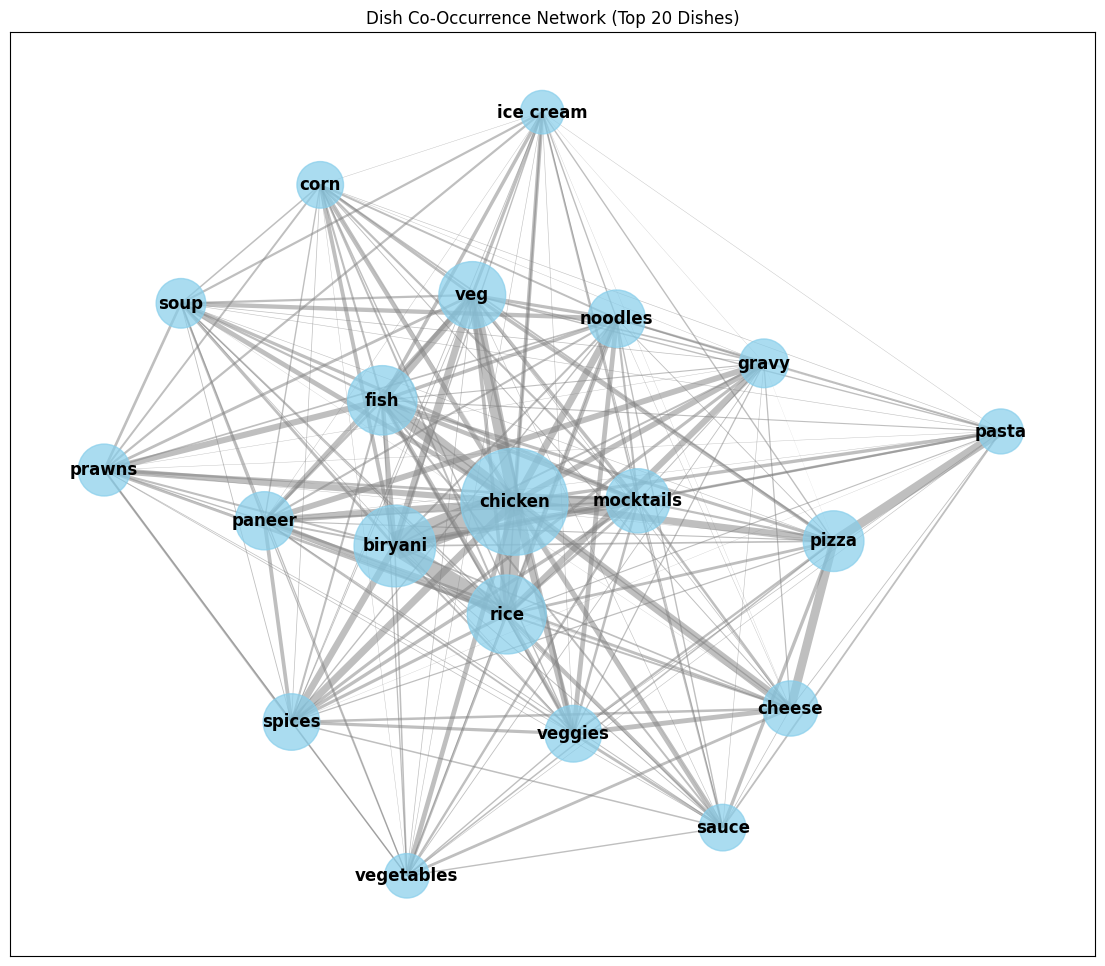

In [145]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_dishes, output=None):
    
    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_dishes, :n_highest_dishes]
    graph = nx.Graph()

    
    for dish in filtered_df.columns:
        graph.add_node(dish, size=filtered_df[dish].sum())

    
    for dish1 in filtered_df.columns:
        for dish2 in filtered_df.columns:
            if dish1 != dish2 and filtered_df.loc[dish1, dish2] > 0:  
                graph.add_edge(dish1, dish2, weight=filtered_df.loc[dish1, dish2])


   
    pos = nx.spring_layout(graph, k=0.5)

   
    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]

    
    node_sizes = [data['size'] * 5 for _, data in graph.nodes(data=True)]

    # Create the network graph
    plt.figure(figsize=(14, 12))
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=12, font_weight='bold')

    plt.title(f"Dish Co-Occurrence Network (Top {n_highest_dishes} Dishes)")
    plt.show()


# Example usage with your co-occurrence matrix
cooccurrence_network_generator(meals_co_occurrence, 20)

In [146]:
meals_co_occurrence

,chicken,biryani,rice,fish,veg,mocktails,pizza,paneer,veggies,noodles,...,peri peri chicken tikka burger,thanx zomatoo,apes,potato fingers,hazelnut cold coffee,veg and egg,cajun omlet,buffalo ranch chicken burger,dunkins,puketh fish
chicken,0,199,127,103,89,77,52,50,47,51,...,0,0,0,0,0,0,0,0,0,0
biryani,199,0,124,33,50,48,12,14,14,15,...,0,0,0,0,0,0,0,0,0,0
rice,127,124,0,34,26,19,20,44,31,34,...,0,0,0,0,0,0,0,0,0,0
fish,103,33,34,0,55,31,22,19,13,25,...,0,0,0,0,0,0,0,0,0,0
veg,89,50,26,55,0,25,25,30,20,23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
double metha,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biryani nd baby corn manchuria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tandoori momos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bamboo chicken n pachi mirchi kodi pulav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances, pairwise_distances
from sklearn.metrics import silhouette_score
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE




In [ ]:
filtered_meals_co_occurrence = meals_co_occurrence.loc[
    meals_co_occurrence.sum(axis=1) > 12, meals_co_occurrence.sum(axis=0) > 12
]

print(f"Matrice filtrata: {filtered_meals_co_occurrence.shape}")

Matrice filtrata: (2917, 2917)


In [ ]:
normalized_meals_co_occurrence = filtered_meals_co_occurrence / filtered_meals_co_occurrence.max().max()

print("Matrice normalizzata:")
print(normalized_meals_co_occurrence.iloc[:10, :10])


Matrice normalizzata:
            chicken   biryani      rice      fish       veg  mocktails  \
chicken    0.000000  1.000000  0.638191  0.517588  0.447236   0.386935   
biryani    1.000000  0.000000  0.623116  0.165829  0.251256   0.241206   
rice       0.638191  0.623116  0.000000  0.170854  0.130653   0.095477   
fish       0.517588  0.165829  0.170854  0.000000  0.276382   0.155779   
veg        0.447236  0.251256  0.130653  0.276382  0.000000   0.125628   
mocktails  0.386935  0.241206  0.095477  0.155779  0.125628   0.000000   
pizza      0.261307  0.060302  0.100503  0.110553  0.125628   0.080402   
paneer     0.251256  0.070352  0.221106  0.095477  0.150754   0.060302   
veggies    0.236181  0.070352  0.155779  0.065327  0.100503   0.090452   
noodles    0.256281  0.075377  0.170854  0.125628  0.115578   0.080402   

              pizza    paneer   veggies   noodles  
chicken    0.261307  0.251256  0.236181  0.256281  
biryani    0.060302  0.070352  0.070352  0.075377  
rice   

In [ ]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

def calculate_distance_matrix(cooccurrence_matrix, metric='cosine', normalize=False):
 
    if normalize:
        cooccurrence_matrix = cooccurrence_matrix / cooccurrence_matrix.max().max()
    
    if metric == 'cosine':
        distance_matrix = pd.DataFrame(
            cosine_distances(cooccurrence_matrix),
            index=cooccurrence_matrix.index,
            columns=cooccurrence_matrix.columns
        )
    elif metric == 'euclidean':
        distance_matrix = pd.DataFrame(
            euclidean_distances(cooccurrence_matrix),
            index=cooccurrence_matrix.index,
            columns=cooccurrence_matrix.columns
        )
    else:
        raise ValueError(f"Metrica '{metric}' non supportata. Usa 'cosine' o 'euclidean'.")
    
    np.fill_diagonal(distance_matrix.values, 0)
    
    return distance_matrix


In [ ]:
distance_matrix_cosine = calculate_distance_matrix(filtered_meals_co_occurrence, metric='cosine', normalize=False)
distance_matrix_cosine_normalized = calculate_distance_matrix(filtered_meals_co_occurrence, metric='cosine', normalize=True)
distance_matrix_euclidean = calculate_distance_matrix(filtered_meals_co_occurrence, metric='euclidean', normalize=False)
distance_matrix_euclidean_normalized = calculate_distance_matrix(filtered_meals_co_occurrence, metric='euclidean', normalize=True)



In [ ]:
distance_matrix_cosine = calculate_distance_matrix(filtered_meals_co_occurrence, metric='cosine', normalize=False)

clusterer_hdb_cosine = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=77, min_samples=5)
clusters_hdb_cosine = clusterer_hdb_cosine.fit(distance_matrix_cosine.values)

print("Distribuzione dei cluster (HDBSCAN - Coseno Non Normalizzato):")
print(pd.Series(clusters_hdb_cosine.labels_).value_counts())


Distribuzione dei cluster (HDBSCAN - Coseno Non Normalizzato):
-1    1866
 1     717
 0     228
 2     106
dtype: int64


In [ ]:
distance_matrix_cosine_normalized = calculate_distance_matrix(filtered_meals_co_occurrence, metric='cosine', normalize=True)

clusterer_hdb_cosine_normalized = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=15, min_samples=1)
clusters_hdb_cosine_normalized = clusterer_hdb_cosine_normalized.fit(distance_matrix_cosine_normalized.values)

print("Distribuzione dei cluster (HDBSCAN - Coseno Normalizzato):")
print(pd.Series(clusters_hdb_cosine_normalized.labels_).value_counts())


Distribuzione dei cluster (HDBSCAN - Coseno Normalizzato):
-1     2431
 23      74
 50      70
 30      68
 46      67
       ... 
 26      16
 56      15
 36      15
 3       15
 0       15
Length: 64, dtype: int64


In [ ]:
distance_matrix_euclidean = calculate_distance_matrix(filtered_meals_co_occurrence, metric='euclidean', normalize=False)

clusterer_hdb_euclidean = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=15, min_samples=1)
clusters_hdb_euclidean = clusterer_hdb_euclidean.fit(distance_matrix_euclidean.values)

print("Distribuzione dei cluster (HDBSCAN - Euclidea Non Normalizzato):")
print(pd.Series(clusters_hdb_euclidean.labels_).value_counts())


Distribuzione dei cluster (HDBSCAN - Euclidea Non Normalizzato):
 1    3896
-1     488
 0      17
 2      16
dtype: int64


In [ ]:
distance_matrix_euclidean_normalized = calculate_distance_matrix(filtered_meals_co_occurrence, metric='euclidean', normalize=True)

clusterer_hdb_euclidean_normalized = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=45, min_samples=1)
clusters_hdb_euclidean_normalized = clusterer_hdb_euclidean_normalized.fit(distance_matrix_euclidean_normalized.values)

print("Distribuzione dei cluster (HDBSCAN - Euclidea Normalizzato):")
print(pd.Series(clusters_hdb_euclidean_normalized.labels_).value_counts())


Distribuzione dei cluster (HDBSCAN - Euclidea Normalizzato):
 0    2583
-1    1789
 1      45
dtype: int64


In [ ]:
from sklearn.cluster import OPTICS

optics_cosine = OPTICS(metric='precomputed', min_samples=2,min_cluster_size=100, cluster_method='xi')
clusters_optics_cosine = optics_cosine.fit(distance_matrix_cosine.values)

print("Distribuzione dei cluster (OPTICS - Coseno Non Normalizzato):")
print(pd.Series(clusters_optics_cosine.labels_).value_counts())


Distribuzione dei cluster (OPTICS - Coseno Non Normalizzato):
-1    2792
 0     125
dtype: int64


In [ ]:
optics_cosine_normalized = OPTICS(metric='precomputed', min_samples=5, cluster_method='xi')
clusters_optics_cosine_normalized = optics_cosine_normalized.fit(distance_matrix_cosine_normalized.values)

print("Distribuzione dei cluster (OPTICS - Coseno Normalizzato):")
print(pd.Series(clusters_optics_cosine_normalized.labels_).value_counts())


KeyboardInterrupt: 

In [ ]:
optics_euclidean = OPTICS(metric='precomputed', min_samples=5, cluster_method='xi')
clusters_optics_euclidean = optics_euclidean.fit(distance_matrix_euclidean.values)

print("Distribuzione dei cluster (OPTICS - Euclidea Non Normalizzato):")
print(pd.Series(clusters_optics_euclidean.labels_).value_counts())


In [ ]:
optics_euclidean_normalized = OPTICS(metric='precomputed', min_samples=5, cluster_method='xi')
clusters_optics_euclidean_normalized = optics_euclidean_normalized.fit(distance_matrix_euclidean_normalized.values)

print("Distribuzione dei cluster (OPTICS - Euclidea Normalizzata):")
print(pd.Series(clusters_optics_euclidean_normalized.labels_).value_counts())


In [ ]:
def calculate_distance_matrix_v2(cooccurrence_matrix, normalize=False):

    if normalize:
        cooccurrence_matrix = cooccurrence_matrix / cooccurrence_matrix.max().max()
        distance_matrix = 1 - cooccurrence_matrix
    else:
        max_value = cooccurrence_matrix.max().max()
        distance_matrix = max_value - cooccurrence_matrix

    distance_matrix = (distance_matrix + distance_matrix.T) / 2

    np.fill_diagonal(distance_matrix.values, 0)
    
    return distance_matrix


In [ ]:
distance_matrix_non_normalized = calculate_distance_matrix_v2(filtered_meals_co_occurrence, normalize=False).astype('float64')
distance_matrix_normalized = calculate_distance_matrix_v2(filtered_meals_co_occurrence, normalize=True).astype('float64')


In [347]:

clusterer_hdb_non_normalized = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=50, min_samples=5)
clusters_hdb_non_normalized = clusterer_hdb_non_normalized.fit(distance_matrix_non_normalized.values)

print("Distribuzione dei cluster (HDBSCAN - Non Normalizzato):")
print(pd.Series(clusters_hdb_non_normalized.labels_).value_counts())


Distribuzione dei cluster (HDBSCAN - Non Normalizzato):
 2    1425
 0     998
 1     227
-1     208
 3      59
dtype: int64


In [348]:
clusterer_hdb_normalized = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=50, min_samples=5)
clusters_hdb_normalized = clusterer_hdb_normalized.fit(distance_matrix_normalized.values)

print("Distribuzione dei cluster (HDBSCAN - Normalizzato):")
print(pd.Series(clusters_hdb_normalized.labels_).value_counts())


Distribuzione dei cluster (HDBSCAN - Normalizzato):
 2    1425
 0     998
 1     227
-1     208
 3      59
dtype: int64


In [310]:
print("Statistiche della matrice di distanza (Non Normalizzato):")
print(distance_matrix_non_normalized.describe())

print("\nStatistiche della matrice di distanza (Normalizzato):")
print(distance_matrix_normalized.describe())


Statistiche della matrice di distanza (Non Normalizzato):
           chicken      biryani         rice         fish          veg  \
count  2917.000000  2917.000000  2917.000000  2917.000000  2917.000000   
mean    196.937264   197.832019   197.981831   198.113473   198.211862   
std       8.026822     6.684639     5.592042     4.892516     4.944100   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     197.000000   199.000000   198.000000   198.000000   199.000000   
50%     199.000000   199.000000   199.000000   199.000000   199.000000   
75%     199.000000   199.000000   199.000000   199.000000   199.000000   
max     199.000000   199.000000   199.000000   199.000000   199.000000   

         mocktails        pizza       paneer      veggies      noodles  ...  \
count  2917.000000  2917.000000  2917.000000  2917.000000  2917.000000  ...   
mean    198.239973   198.380528   198.366815   198.396640   198.436064  ...   
std       4.536849     4.489876     4.

In [311]:
from sklearn.cluster import OPTICS

optics_non_normalized = OPTICS(metric='precomputed', min_samples=3, cluster_method='xi')
clusters_optics_non_normalized = optics_non_normalized.fit(distance_matrix_non_normalized.values)

print("Distribuzione dei cluster (OPTICS - Non Normalizzato):")
print(pd.Series(clusters_optics_non_normalized.labels_).value_counts())


Distribuzione dei cluster (OPTICS - Non Normalizzato):
-1    2911
 0       6
dtype: int64


In [ ]:
optics_normalized = OPTICS(metric='precomputed', min_samples=5, cluster_method='xi')
clusters_optics_normalized = optics_normalized.fit(distance_matrix_normalized.values)

print("Distribuzione dei cluster (OPTICS - Normalizzato):")
print(pd.Series(clusters_optics_normalized.labels_).value_counts())


Distribuzione dei cluster (OPTICS - Normalizzato):
-1    2909
 0       8
dtype: int64


In [ ]:
from sklearn.metrics import pairwise_distances

def manual_silhouette_score(distance_matrix, labels):

    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print("Non ci sono abbastanza cluster validi per il calcolo.")
        return 0.0

    silhouette_scores = []
    for i, label in enumerate(labels):
        if label == -1:
            continue  
        same_cluster = labels == label
        other_clusters = labels != label
        a = np.mean(distance_matrix[i][same_cluster])  
        b = np.min([np.mean(distance_matrix[i][labels == l]) for l in unique_labels if l != label])  
        silhouette_scores.append((b - a) / max(a, b))

    return np.mean(silhouette_scores)


In [ ]:
filtered_distance_matrix = distance_matrix_non_normalized.loc[valid_indices, valid_indices]
manual_score = manual_silhouette_score(filtered_distance_matrix.values, valid_labels)
print(f"Silhouette Score calcolato manualmente: {manual_score:.3f}")


Silhouette Score calcolato manualmente: 0.002


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters_2d(distance_matrix, labels, title="2D Cluster Visualization"):
   
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(distance_matrix)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='Spectral', s=10, alpha=0.8)
    plt.colorbar(scatter, label='Cluster')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()


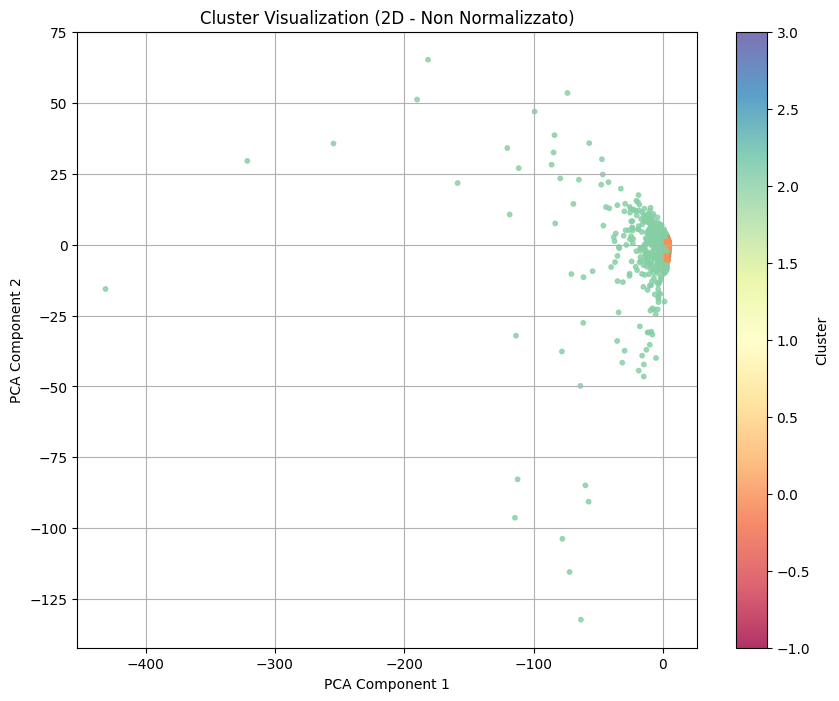

In [352]:
plot_clusters_2d(distance_matrix_non_normalized.values, clusters_hdb_non_normalized.labels_, title="Cluster Visualization (2D - Non Normalizzato)")


In [ ]:
import plotly.express as px
from sklearn.decomposition import TruncatedSVD
import numpy as np

def plot_clusters_3d(distance_matrix, labels, title="3D Cluster Visualization"):
   
    svd = TruncatedSVD(n_components=3)
    reduced_data = svd.fit_transform(distance_matrix)
    
    data_3d = {
        'SVD1': reduced_data[:, 0],
        'SVD2': reduced_data[:, 1],
        'SVD3': reduced_data[:, 2],
        'Cluster': labels
    }
    
    fig = px.scatter_3d(
        data_3d, x='SVD1', y='SVD2', z='SVD3',
        color='Cluster', opacity=0.7,
        color_discrete_sequence=px.colors.qualitative.Alphabet,
        title=title
    )
    fig.show()


In [ ]:
plot_clusters_3d(distance_matrix_non_normalized.values, clusters_hdb_non_normalized.labels_, title="Cluster Visualization (3D - Non Normalizzato)")

###????
